In [1]:
# this notebook is the implentation of VAE in cifar10 dataset
from keras.layers import Dense, Lambda, Input
from keras.models import Model, load_model
from keras.losses import binary_crossentropy, mse
from keras.utils import plot_model
from keras import backend
from keras.optimizers import Adam
from keras.datasets import cifar10

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load the cifar10 data by keras library
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [3]:
img_size = x_train[0].shape
print(img_size)
expand_dim = 32*32*3

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, [-1, expand_dim])
x_test = np.reshape(x_test, [-1, expand_dim])

(32, 32, 3)


## **Build the VAE model**

In [4]:
# define the sample function for sampling varibles
# Uses (z_mean, z_log_var) to sample z, the vector encoding a digit. 
def sampling(mean_var):

  z_mean, z_log_var = mean_var
  batch = backend.shape(z_mean)[0]
  dim = backend.int_shape(z_mean)[1]
  epsilon = backend.random_normal(shape=(batch, dim))
  return z_mean + backend.exp(0.5 * z_log_var)* epsilon

In [5]:
input_shape = (expand_dim, )
model_complexity = 512
batch_size = 100
latent_dim = 2
epochs = 50

In [6]:
def VAE_model(latent_dim=2, model_complexity=512):

  # Encoder
  inputs = Input(shape=input_shape)
  h = Dense(model_complexity, activation='relu')(inputs)
  z_mean = Dense(latent_dim)(h)
  z_log_var = Dense(latent_dim)(h)
  z = Lambda(sampling, output_shape=(latent_dim, ))([z_mean, z_log_var])

  encoder = Model(inputs, [z_mean, z_log_var, z])

  # Decoder
  latent_space_inputs = Input(shape=(latent_dim, ))
  x = Dense(model_complexity, activation='relu')(latent_space_inputs)
  outputs = Dense(expand_dim, activation='sigmoid')(x)

  decoder = Model(latent_space_inputs, outputs)

  outputs = decoder(encoder(inputs)[2])
  vae = Model(inputs, outputs)
  vae.summary()
  # Loss
  reconstruction_loss = binary_crossentropy(inputs, outputs) * expand_dim
  kl_loss = 1 + z_log_var - backend.square(z_mean) - backend.exp(z_log_var)
  kl_loss = backend.sum(kl_loss, axis=-1) 
  kl_loss = kl_loss * -0.5
  vae_loss = backend.mean(reconstruction_loss+kl_loss)

  vae.add_loss(vae_loss)
  vae.compile(optimizer=Adam())

  return vae

In [7]:
vae_origin_model = VAE_model()
# vae_origin_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
model (Functional)           [(None, 2), (None, 2), (N 1575428   
_________________________________________________________________
model_1 (Functional)         (None, 3072)              1577472   
Total params: 3,152,900
Trainable params: 3,152,900
Non-trainable params: 0
_________________________________________________________________


In [8]:
vae_orig_hist = vae_origin_model.fit(
    x_train, shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None)
)

Epoch 1/50
500/500 [==============================] - 40s 79ms/step - loss: 2030.5379 - val_loss: 1965.5608
Epoch 2/50
500/500 [==============================] - 39s 78ms/step - loss: 1962.8780 - val_loss: 1962.8732
Epoch 3/50
500/500 [==============================] - 39s 78ms/step - loss: 1960.6773 - val_loss: 1963.8726
Epoch 4/50
500/500 [==============================] - 39s 78ms/step - loss: 1958.8273 - val_loss: 1960.5383
Epoch 5/50
500/500 [==============================] - 39s 77ms/step - loss: 1958.5363 - val_loss: 1959.9331
Epoch 6/50
500/500 [==============================] - 39s 78ms/step - loss: 1958.5418 - val_loss: 1961.6414
Epoch 7/50
500/500 [==============================] - 39s 77ms/step - loss: 1958.9036 - val_loss: 1959.2499
Epoch 8/50
500/500 [==============================] - 39s 77ms/step - loss: 1957.2361 - val_loss: 1958.9851
Epoch 9/50
500/500 [==============================] - 39s 78ms/step - loss: 1957.0891 - val_loss: 1959.0503
Epoch 10/50
500/500 [=======

**Plot loss function**

In [10]:
def lossPlot(train, test):
  x_axis = list(range(len(train)))

  plt.plot(x_axis, train, label='train loss')
  plt.plot(x_axis, test, label='test loss')

  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.grid(True, linestyle='dotted')
  plt.legend()

  plt.show()

**Plot images gallery function**

In [11]:
def images_gallery(images):
  fig = plt.figure(figsize=(4, 12))
  for index, image in enumerate(images):
    axis_1 = fig.add_subplot(10, 2, index*2+1)
    axis_1.imshow(image[0], cmap=plt.cm.gray)

    axis_2 = fig.add_subplot(10, 2, index*2+2)
    axis_2.imshow(image[1], cmap=plt.cm.gray)

In [16]:
def plot_gallary(x_test_encoded):
  digits = [0,1,2,3,4,5,6,7,8,9]
  images = []

  for digit in digits:
    first_index = np.where(y_test==digit)[0]
    ind = first_index[np.random.choice(first_index.shape[0])]

    original_img = x_test[ind].reshape(32, 32, 3)
    encoded = x_test_encoded[ind].reshape(32, 32, 3)

    images.append([original_img, encoded])

  images_gallery(images)


## **Results**

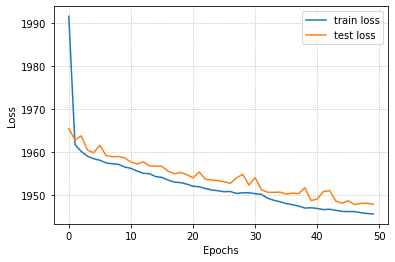

In [14]:
hist_origin = vae_orig_hist.history
lossPlot(hist_origin['loss'], hist_origin['val_loss'])

Latent dimension: 2
Model complexity: 512


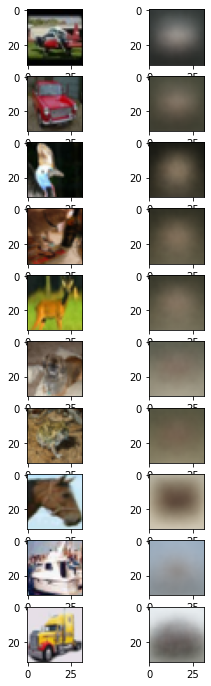

In [17]:
x_test_predict = vae_origin_model.predict(x_test, batch_size=batch_size)
print('Latent dimension: 2')
print('Model complexity: 512')
plot_gallary(x_test_encoded=x_test_predict)

## **Tuning Hyperprameters**

### **Latent** **Dimension** 

In [18]:
latent_models = []
latent_hists = []
for latent in [10, 20]:
  latent_model = VAE_model(latent_dim=latent)
  latent_hist = latent_model.fit(
      x_train, shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None)
  )

  latent_models.append(latent_model)
  latent_hists.append(latent_hist)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
model_3 (Functional)         [(None, 10), (None, 10),  1583636   
_________________________________________________________________
model_4 (Functional)         (None, 3072)              1581568   
Total params: 3,165,204
Trainable params: 3,165,204
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
500/500 [==============================] - 39s 78ms/step - loss: 1984.9178 - val_loss: 1878.1936
Epoch 2/50
500/500 [==============================] - 39s 79ms/step - loss: 1876.2935 - val_loss: 1874.8403
Epoch 3/50
500/500 [==============================] - 39s 78ms/step - loss: 1871.4741 - val_loss: 1873.1714
Epoch 4/50
500/500 [==============================] - 3

### **Model Complexity**

In [19]:
comp_models = []
comp_hists = []

for comp in [256, 1024]:
  comp_model = VAE_model(model_complexity=comp)
  comp_hist = comp_model.fit(
      x_train, shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None)
  )

  comp_models.append(comp_model)
  comp_hists.append(comp_hist)

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
model_9 (Functional)         [(None, 2), (None, 2), (N 787716    
_________________________________________________________________
model_10 (Functional)        (None, 3072)              790272    
Total params: 1,577,988
Trainable params: 1,577,988
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
500/500 [==============================] - 22s 42ms/step - loss: 2030.0772 - val_loss: 1965.6836
Epoch 2/50
500/500 [==============================] - 21s 42ms/step - loss: 1961.7995 - val_loss: 1964.2427
Epoch 3/50
500/500 [==============================] - 21s 42ms/step - loss: 1960.3932 - val_loss: 1961.6014
Epoch 4/50
500/500 [==============================] - 

## **Results Display**

Latent dimension: 10


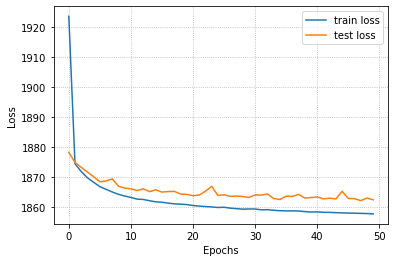

In [20]:
print('Latent dimension: 10')
latent_10_hist = latent_hists[0].history
lossPlot(latent_10_hist['loss'], latent_10_hist['val_loss'])

Latent dimension: 10
Model complexity: 512


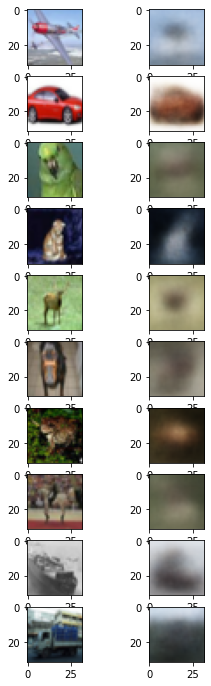

In [21]:
latent_model_10 =latent_models[0]
x_test_predict_10 = latent_model_10.predict(x_test, batch_size=batch_size)
print('Latent dimension: 10')
print('Model complexity: 512')
plot_gallary(x_test_encoded=x_test_predict_10)

Latent dimension: 20


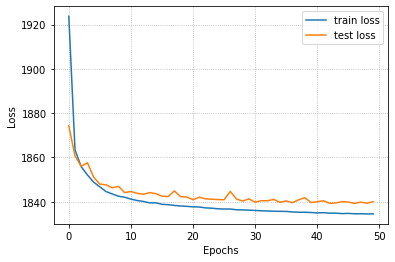

In [22]:
print('Latent dimension: 20')
latent_20_hist = latent_hists[1].history
lossPlot(latent_20_hist['loss'], latent_20_hist['val_loss'])

Latent dimension: 20
Model complexity: 512


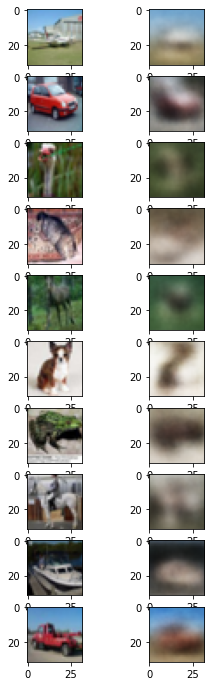

In [23]:
latent_model_20 =latent_models[1]
x_test_predict_20 = latent_model_20.predict(x_test, batch_size=batch_size)
print('Latent dimension: 20')
print('Model complexity: 512')
plot_gallary(x_test_encoded=x_test_predict_20)

Model complexity: 256


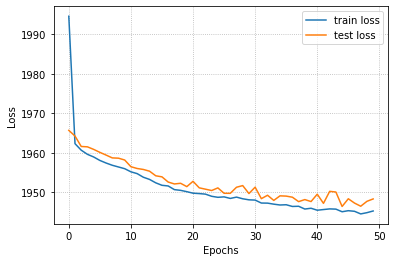

In [25]:
print('Model complexity: 256')
comp_256_hist = comp_hists[0].history
lossPlot(comp_256_hist['loss'], comp_256_hist['val_loss'])

Latent dimension: 2
Model complexity: 256


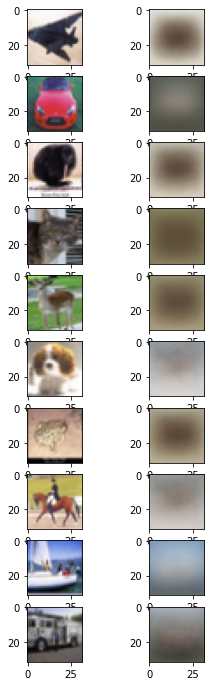

In [27]:
comp_models_256 = comp_models[0]
x_test_predict_256 = comp_models_256.predict(x_test, batch_size=batch_size)
print('Latent dimension: 2')
print('Model complexity: 256')
plot_gallary(x_test_encoded=x_test_predict_256)

Model complexity: 1024


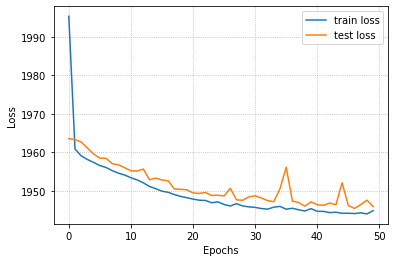

In [26]:
print('Model complexity: 1024')
comp_1024_hist = comp_hists[1].history
lossPlot(comp_1024_hist['loss'], comp_1024_hist['val_loss'])

Latent dimension: 2
Model complexity: 1024


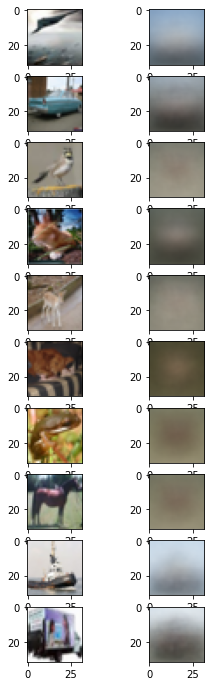

In [28]:
comp_models_1024 = comp_models[1]
x_test_predict_1024 = comp_models_1024.predict(x_test, batch_size=batch_size)
print('Latent dimension: 2')
print('Model complexity: 1024')
plot_gallary(x_test_encoded=x_test_predict_1024)